## Kaggle房价预测

In [13]:
import torch
import torch.nn as nn 
import numpy as np 
import pandas as pd 
import d2lzh as d2l 

print(torch.__version__)
torch.set_default_dtype(torch.float32)

1.0.1


In [14]:
train_data = pd.read_csv("../../Datasets/kaggle_house/train.csv")
test_data = pd.read_csv("../../Datasets/kaggle_house/test.csv")

print(train_data.shape)
print(test_data.shape)
train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]

(1460, 81)
(1459, 80)


,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [15]:
# 第一列为id，不需要该特征进行训练。　将训练数据和测试数据连接到一起
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:-1]))

## 数据的预处理
对于连续数值的特征做标准化：假设该特征在整个数据集上的均值为$\mu$，标准差为$\sigma$，可以将该特征的每个值减去均值后再除以标准差。　对于缺失的特征值，将其替换为特征的均值。

In [16]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(lambda x:(x - x.mean()) / (x.std()))
all_features = all_features.fillna(0) # 缺失值填充０，标准化后每个特征的均值变为０

In [17]:
print(all_features.shape)

all_features = pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2919, 79)


(2919, 355)

In [21]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values,dtype=torch.float)
test_features = torch.tensor(all_features[n_train:].values,dtype=torch.float)
train_labels = torch.tensor(train_data.SalePrice.values,dtype=torch.float).view(-1,1)

loss = torch.nn.MSELoss()

def get_net(feature_num):
    net = nn.Linear(feature_num,1)
    for param in net.parameters():
        nn.init.normal_(param,mean=0,std=0.01)

    return net

# 对数均方根误差
def log_rmse(net,features,labels):
    with torch.no_grad():
        # 将小于１的值设为１，这样取对数时数值更稳定
        clipped_preds = torch.max(net(features),torch.tensor(1.0))
        rmse = torch.sqrt(2 * loss(clipped_preds.log(),labels.log()).mean())
    return rmse.item()


def train(net,train_features,train_labels,test_features,test_labels,num_epochs,lr,wd,batch_size):
    train_ls,test_ls = [],[]

    dataset = torch.utils.data.TensorDataset(train_features,train_labels)
    train_iter = torch.utils.data.DataLoader(dataset,batch_size,shuffle=True)

    optimizer = torch.optim.Adam(params=net.parameters(),lr=lr,weight_decay=wd)
    net = net.float()

    for epoch in range(num_epochs):
        for X,y in train_iter:
            l = loss(net(X.float()),y.float())
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net,test_features,test_labels))

    return train_ls,test_ls

fold 0,train rmse 0.240616,valid rmse 0.222449
fold 1,train rmse 0.229787,valid rmse 0.269631
fold 2,train rmse 0.231725,valid rmse 0.238200
fold 3,train rmse 0.237796,valid rmse 0.219209
fold 4,train rmse 0.230423,valid rmse 0.258200
5-fold validation: avg train rmse 0.234069,avg valid rmse 0.241538


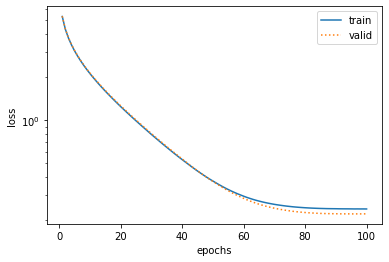

In [22]:
def get_k_fold_data(k,i,X,y):
    assert k > 1

    fold_size = X.shape[0] // k
    X_train,y_train = None,None

    for j in range(k):
        idx = slice(j * fold_size,(j + 1) * fold_size)
        X_part,y_part = X[idx,:],y[idx]
        if j == i:
            X_valid,y_valid = X_part,y_part
        elif X_train is None:
            X_train,y_train = X_part,y_part
        else:
            X_train = torch.cat((X_train,X_part),dim=0)
            y_train = torch.cat((y_train,y_part),dim=0)

    return X_train,y_train,X_valid,y_valid

def k_fold(k,X_train,y_train,num_epochs,lr,wd,batch_size):
    train_l_sum = 0
    valid_l_sum = 0
    for i in range(k):
        data = get_k_fold_data(k,i,X_train,y_train)
        net = get_net(X_train.shape[1])
        train_ls,valid_ls = train(net,*data,num_epochs,lr,wd,batch_size)

        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]

        if i == 0:
            d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','loss',range(1,num_epochs+1),valid_ls,['train','valid'])
        
        print('fold %d,train rmse %f,valid rmse %f'%(i,train_ls[-1],valid_ls[-1]))

    return train_l_sum / k,valid_l_sum / k

k,num_epochs,lr,wd,batch_size = 5,100,5,0,64
train_l,valid_l = k_fold(k,train_features,train_labels,num_epochs,lr,wd,batch_size)
print('%d-fold validation: avg train rmse %f,avg valid rmse %f' % (k,train_l,valid_l))

train rmse 0.229619


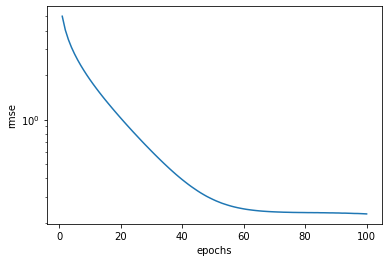

In [23]:
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,wd,batch_size):

    net = get_net(train_features.shape[1])
    train_ls,_ = train(net,train_features,train_labels,None,None,num_epochs,lr,wd,batch_size)
    d2l.semilogy(range(1,num_epochs + 1),train_ls,'epochs','rmse')
    print('train rmse %f'% train_ls[-1])
    preds = net(test_features).detach().numpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    submission = pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    submission.to_csv('./submission.csv',index=False)

    
train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,wd,batch_size)